# __Assignment 1: Camera Calibration__
### <br>__Laksh Nanwani - 2021701002__
---

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import rq
import math

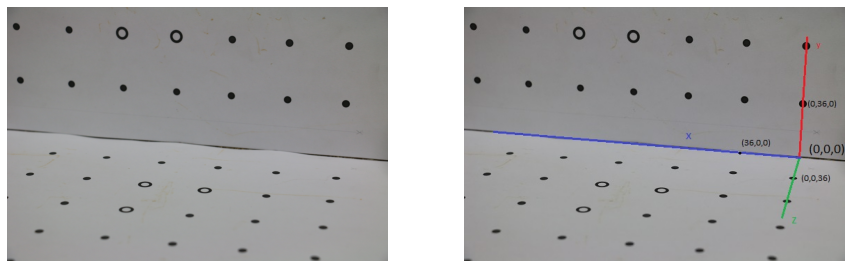

In [2]:
dots_img = cv2.cvtColor(cv2.imread("../data/black-dots.JPG"), cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1,2, figsize=(15,10))
axes[0].imshow(dots_img)
axes[0].axis("off")
axes[1].imshow(cv2.cvtColor(cv2.imread("../data/measurements.jpg"), cv2.COLOR_BGR2RGB))
axes[1].axis("off")
plt.show()

__1. Implement the DLT (Direct Linear Transformation) based calibration that we discussed in the class. You could
use C/C++, Python or Matlab for this. However, you are expected to implement it yourselves and not use an
existing implementation.__

In [3]:
def get_M(X, x):
    num_points = x.shape[0]
    M = []
    for i in range(num_points):
        xt, yt = x[i,0], x[i,1]
#         print(xt,yt)
        Xt, Yt, Zt = X[i,0], X[i,1], X[i,2]
        M.append([-Xt, -Yt, -Zt, -1, 0, 0, 0, 0, xt*Xt, xt*Yt, xt*Zt, xt])
        M.append([0, 0, 0, 0, -Xt, -Yt, -Zt, -1, yt*Xt, yt*Yt, yt*Zt, yt])
    return np.asarray(M)
 
def dlt_calibrate(X, x):
    M = get_M(X, x)
    U,D,Vt = np.linalg.svd(M, full_matrices = False)
    p = Vt[-1,:] / Vt[-1,-1]
    P = p.reshape(3,4)
    return P

def project(X, P):
    N = len(X)
    X_homo = np.vstack((X.T, np.ones(N)))
    x_hat = P @ X_homo
    x_hat = x_hat / x_hat[2:]
    return x_hat[0:2].T

def reprojection_error(X, x, P):
    x_hat = project(X, P)
    return np.sqrt(np.square(x - x_hat).mean())  # rmse

__DLT__:
Algo: This algo works by taking non planar 2d-3d correspondences between image and real world and calculatiing a matrix M (defined below). Then we do singular value decomposition (SVD) of M and obtain the P matrix.

M = $$\begin{bmatrix} -Xt & -Yt& -Zt & -1 & 0 & 0 & 0 & 0 & xt*Xt & xt*Yt & xt*Zt & xt \\ 0 & 0 & 0 & 0 & -Xt & -Yt & -Zt & -1 & yt*Xt & yt*Yt & yt*Zt & yt\end{bmatrix}$$

This matrix has the shape (2n, 12), where n is the number of point correspondeces, and n >= 6. All these n points should be non planar in real world, or else a solution will not be found.


__2. Implement the RANSAC based variant of the calibration that we discussed in the class. Note that these two
algorithms use a set of known correspondences between real-world points and image points.__

In [4]:
def ransac(X, x, num_iters, eps, num_points = 6, set_seed = False):
    N = X.shape[0]
    P_collect = []
    counts = []
    for i in range(num_iters):
        if set_seed:
            np.random.seed(i)
        indices = np.random.choice(N, num_points, replace = False)
        X_i = X[indices]
        x_i = x[indices]
        P_i = dlt_calibrate(X_i, x_i)
        
        x_hat = project(X, P_i)
        # print((np.sum((x_hat - x) ** 2, axis = 1) < eps))
        count = ((np.sum((x_hat - x) ** 2, axis = 1) < eps)).sum()
        counts.append(count)
        P_collect.append(P_i)
    
    counts = np.array(counts)
    max_index = np.argmax(counts)
    # print(counts)
    return P_collect[max_index]

__RANSAC - Random sample consensus__

Algo: Considering all the point correspondences between the image(2D) and the world(3D), the algo randomly selects 6 points (minimum number of points required for DLT to work)and inserts them into the DLT method and hence we obtain a projection matrix P. This world points are now projected back onto the image using P and an error is calculated between the original image points and the projected ones. Projected points with error below a threshold are considered as votes for this particular P. This process is repeated for a number of iterations and the P with maximum votes is returned as the final P.

Possible limitation: As RANSAC selects points randomly, there is a chance that it may select 6 planar points and hence the DLT call will fail.

Challenges faced: NA

__3. Use the image that is provided along with this assignment along with the real-world measurements that are given
to you to compute the camera’s internal and external parameters using each of the above algorithms. Note that
you need to manually estimate the image co-ordinates of the given world points. You may implement and use
the Harris Corner detector to help select these points. Describe your observations regarding the results.__

In [5]:
def KRT_decomposition(P):
    M = P[:,0:3]
    K, R = rq(M)
    p4 = P[:,3].reshape((-1,1))
    t = np.linalg.inv(K) @ p4
    return K, R, t

In [6]:
# x,y format, found by using hovering tool
image_points = np.array([[140, 890, 1650, 2435, 3235, 4055, 4920, 
                          190, 935, 1675, 2435, 3220, 4030, 4865, 
                          660, 1430, 2230, 3030, 3870, 4730, 
                          325, 1150, 1985, 2840, 3730, 4640, 
                          825, 1720, 2630, 3565, 4540, 
                          460, 1400, 2380, 3390, 4425],
                         [280, 330, 370, 420, 465, 525, 560,
                         1045, 1100, 1160, 1215, 1280, 1330, 1390,
                         2100, 2160, 2230, 2310, 2385, 2455,
                         2400, 2460, 2550, 2635, 2710, 2790,
                         2820, 2910, 2990, 3075, 3165,
                         3215, 3310, 3400, 3500, 3600]])

# as per measurements
world_points = np.array([[216, 180, 144, 108, 72, 36, 0,
                         216, 180, 144, 108, 72, 36, 0,
                         180, 144, 108, 72, 36, 0,
                         180, 144, 108, 72, 36, 0,
                         144, 108, 72, 36, 0,
                         144, 108, 72, 36, 0],
                        [72, 72, 72, 72, 72, 72, 72,
                        36, 36, 36, 36, 36, 36, 36,
                        0, 0, 0, 0, 0, 0,
                        0, 0, 0, 0, 0, 0,
                        0, 0, 0, 0, 0,
                        0, 0, 0, 0, 0],
                        [0, 0, 0, 0, 0, 0, 0,
                        0, 0, 0, 0, 0, 0, 0,
                        36, 36, 36, 36, 36, 36,
                        72, 72, 72, 72, 72, 72,
                        108, 108, 108, 108, 108,
                        144, 144, 144, 144, 144]])

In [7]:
# x,y format, found by using hovering tool
image_points_dlt = np.array([[1650, 3235, 2435, 1430, 2840, 1720],
                         [370, 465, 1100, 2160, 2635, 2910]])

# as per measurements
world_points_dlt = np.array([[144, 72,108, 144, 72, 108],
                        [72, 72, 36, 0, 0, 0],
                        [0, 0, 0, 36, 72, 108]])

In [8]:
image_points_dlt.T

array([[1650,  370],
       [3235,  465],
       [2435, 1100],
       [1430, 2160],
       [2840, 2635],
       [1720, 2910]])

In [9]:
world_points_dlt.T

array([[144,  72,   0],
       [ 72,  72,   0],
       [108,  36,   0],
       [144,   0,  36],
       [ 72,   0,  72],
       [108,   0, 108]])

In [10]:
P_dlt = dlt_calibrate(world_points_dlt.T, image_points_dlt.T)
P_dlt

array([[-2.32256926e+01,  1.09680061e+00, -7.56514158e+00,
         5.10435989e+03],
       [-1.09151020e+00, -2.06688747e+01,  9.77163855e+00,
         2.06065792e+03],
       [ 3.83001170e-04,  8.45844753e-04, -1.17649762e-04,
         1.00000000e+00]])

In [11]:
KRT_decomposition(P_dlt)

(array([[-8.83380832e+00,  2.15091865e+01, -7.56213341e+00],
        [ 0.00000000e+00, -1.04682579e+01, -2.03542201e+01],
        [ 0.00000000e+00,  0.00000000e+00,  9.35940547e-04]]),
 array([[ 0.59540715, -0.36887691, -0.71373675],
        [-0.69139944,  0.21722801, -0.68904195],
        [ 0.40921528,  0.90373769, -0.12570217]]),
 array([[-7030.09420289],
        [-2274.30401256],
        [ 1068.44393346]]))

In [12]:
reprojection_error(world_points.T, image_points.T, P_dlt)

76.53905186441973

In [13]:
P_ransac = ransac(world_points.T, image_points.T, 50, 0.1, num_points = 6, set_seed = True)
P_ransac

array([[-2.10537200e+01, -1.23735538e+00, -9.71930543e+00,
         4.79513038e+03],
       [-1.11430802e+00, -2.26995333e+01,  4.15293954e+00,
         2.17445197e+03],
       [ 4.25565949e-04, -6.53559603e-04, -1.69948170e-03,
         1.00000000e+00]])

In [14]:
K_ransac, R_ransac, T_ransac = KRT_decomposition(P_ransac)
K_ransac, R_ransac, T_ransac

(array([[-2.27850395e+01, -2.76335633e-01,  4.47444806e+00],
        [ 0.00000000e+00,  2.27706391e+01,  3.90581581e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.86988892e-03]]),
 array([[ 0.96977515, -0.00296855,  0.24398227],
        [-0.08797418, -0.93692499,  0.33827814],
        [ 0.22758889, -0.34951788, -0.90886773]]),
 array([[-105.475997  ],
        [   3.76170086],
        [ 534.79112547]]))

In [15]:
reprojection_error(world_points.T, image_points.T, P_ransac)

19.863886570421286

In [16]:
P_dlt_all = dlt_calibrate(world_points.T, image_points.T)
P_dlt_all

array([[-2.10468421e+01, -1.57601497e+00, -9.71358328e+00,
         4.80076993e+03],
       [-1.15364074e+00, -2.24704869e+01,  4.30707549e+00,
         2.15958669e+03],
       [ 3.31129308e-04, -6.32650040e-04, -1.60481788e-03,
         1.00000000e+00]])

In [17]:
K_dlt_all, R, T = KRT_decomposition(P_dlt_all)
K_dlt_all, R, T

(array([[-2.25789201e+01, -1.64705956e-01,  5.47469862e+00],
        [ 0.00000000e+00,  2.25671328e+01,  3.94069601e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.75651164e-03]]),
 array([[ 0.97846789, -0.0107263 ,  0.2061202 ],
        [-0.08403913, -0.93282343,  0.35039674],
        [ 0.18851529, -0.36017412, -0.9136392 ]]),
 array([[-74.55431219],
        [ -3.71743139],
        [569.31020474]]))

In [18]:
reprojection_error(world_points.T, image_points.T, P_dlt_all)

6.337347752677584

__Observations:__ Ransac gave a much better projection matrix (lower error) compared to manually giving 6 non planar points. Whereas, DLT on all the correspondences taken together gave the lowest error.

__Experiments:__ Tried different number of iterations and thresold values with Ransac. Also tried running ransac with and without setting seed points.

__4. Repeat the above experiments after correcting for radial distortion. Estimate the radial distortion parameters
from the straight lines in the image. What do you observe regarding the resulting parameters?__

In [19]:
left_img = cv2.cvtColor(cv2.imread("../images/left05.jpg"), cv2.COLOR_BGR2RGB)

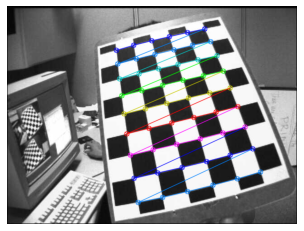

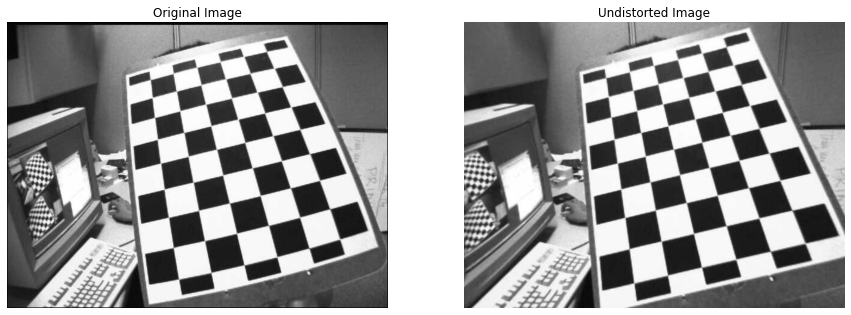

In [20]:
img = left_img.copy()
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:6,0:9].T.reshape(-1,2)

objpoints = []
imgpoints = []

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (6,9), None)
if ret == True:
    objpoints.append(objp)
    corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
    imgpoints.append(corners2)
    cv2.drawChessboardCorners(img, (6,9), corners, ret)
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
new_img = cv2.undistort(left_img, K, dist, None, K)

fig, axes = plt.subplots(1,2, figsize=(15,10))
axes[0].imshow(left_img)
axes[0].set_title('Original Image')
axes[0].axis("off")
axes[1].imshow(new_img)
axes[1].set_title('Undistorted Image')
axes[1].axis("off")
plt.show()

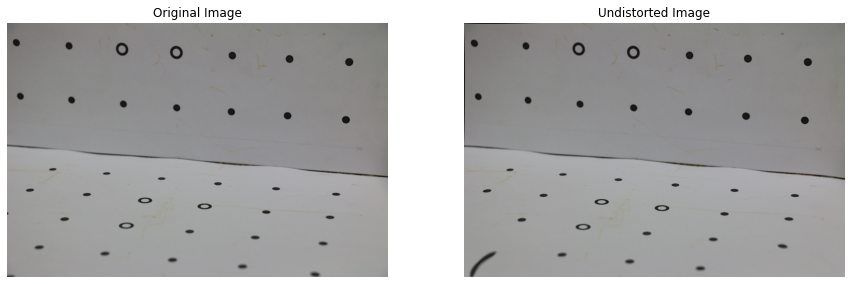

In [21]:
gray = cv2.cvtColor(dots_img, cv2.COLOR_BGR2GRAY)

# only taking z = 0 points, planar points
ret, K, dist, rvecs, tvecs = cv2.calibrateCamera([world_points.T.astype("float32")[:14]], 
                                                 [image_points.T.astype("float32")[:14]], 
                                                 gray.shape[::-1],
                                                 None, None)

new_dots = cv2.undistort(dots_img, K, dist, None, K)

fig, axes = plt.subplots(1,2, figsize=(15,10))
axes[0].imshow(dots_img)
axes[0].set_title('Original Image')
axes[0].axis("off")
axes[1].imshow(new_dots)
axes[1].set_title('Undistorted Image')
axes[1].axis("off")
plt.show()

In [22]:
dist

array([[-1.36093719e+00,  4.98340431e+01, -1.04508065e-02,
        -1.15206922e-02, -4.73116186e+02]])

__Distortion__

Radial Distortion
<br>x<sub>distorted</sub> = x(1 + k<sub>1</sub> r<sup>2</sup> + k<sub>2</sub> r<sup>4</sup> + k<sub>3</sub> r<sup>6</sup>)
<br>y<sub>distorted</sub> = y(1 + k<sub>1</sub> r<sup>2</sup> + k<sub>2</sub> r<sup>4</sup> + k<sub>3</sub> r<sup>6</sup>)

<br>Tangential distortion
x<sub>distorted</sub>=x+[2p<sub>1</sub>xy+p<sub>2</sub>(r<sup>2</sup>+2x<sup>2</sup>)]
<br>y<sub>distorted</sub>=y+[p<sub>1</sub>(r<sup>2</sup>+2y<sup>2</sup>)+2p<sub>2</sub>xy]

The method cv2.calibrateCamera returns the radial and tangetial distortion coefficients in the order (k1, k2, p1, p2, k3)

The method cv2.undistort then takes these parameters and returns the undistorted image

__Observations:__ The dots image has quite small tangential distortion parameters compared to radial distortion parameters. We can also observe that few points have been cut out of the new image at the bottom.

In [23]:
cv2.imwrite("../images/dots_undistorted.jpg", new_dots)

True

In [24]:
# x,y format, found by using hovering tool, on undistorted image
image_points_undis = np.array([[152, 886, 1650, 2435, 3240, 4080, 4940, 
                          208, 925, 1675, 2435, 3233, 4052, 4897, 
                          664, 1424, 2221, 3036, 3885, 4756, 
                          336, 1150, 1985, 2840, 3740, 4675, 
                          835, 1720, 2630, 3582, 4585, 
                          1402, 2380, 3399],
                         [292, 330, 373, 433, 471, 514, 556,
                         1056, 1111, 1171, 1222, 1282, 1337, 1400,
                         2097, 2169, 2250, 2323, 2408, 2476,
                         2412, 2476, 2574, 2660, 2837, 2818,
                         2822, 2929, 3018, 3108, 3202,
                         3324, 3428, 3522]])

# as per measurements
world_points_undis = np.array([[216, 180, 144, 108, 72, 36, 0,
                         216, 180, 144, 108, 72, 36, 0,
                         180, 144, 108, 72, 36, 0,
                         180, 144, 108, 72, 36, 0,
                         144, 108, 72, 36, 0,
                         108, 72, 36],
                        [72, 72, 72, 72, 72, 72, 72,
                        36, 36, 36, 36, 36, 36, 36,
                        0, 0, 0, 0, 0, 0,
                        0, 0, 0, 0, 0, 0,
                        0, 0, 0, 0, 0,
                        0, 0, 0,],
                        [0, 0, 0, 0, 0, 0, 0,
                        0, 0, 0, 0, 0, 0, 0,
                        36, 36, 36, 36, 36, 36,
                        72, 72, 72, 72, 72, 72,
                        108, 108, 108, 108, 108,
                        144, 144, 144]])

In [25]:
image_points_undis.shape

(2, 34)

In [26]:
world_points_undis.shape

(3, 34)

In [27]:
P_dlt_undis = dlt_calibrate(world_points_undis.T, image_points_undis.T)
P_dlt_undis

array([[-2.11549639e+01, -1.50308424e+00, -9.75179382e+00,
         4.83812298e+03],
       [-1.06808946e+00, -2.29367645e+01,  4.42217364e+00,
         2.19145817e+03],
       [ 4.40936929e-04, -6.04563157e-04, -1.59388270e-03,
         1.00000000e+00]])

In [28]:
KRT_decomposition(P_dlt_undis)

(array([[-2.29895512e+01, -2.75908843e-02,  4.04586407e+00],
        [ 0.00000000e+00,  2.31040443e+01,  3.60482168e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.76079074e-03]]),
 array([[ 0.96437211,  0.00608363,  0.26447953],
        [-0.08530144, -0.93918873,  0.33263825],
        [ 0.25041984, -0.34334753, -0.90520847]]),
 array([[-110.50851281],
        [   6.24063242],
        [ 567.92665666]]))

In [29]:
reprojection_error(world_points_undis.T, image_points_undis.T, P_dlt_undis)

13.846808336894478

In [30]:
P_ransac_undis = ransac(world_points_undis.T, image_points_undis.T, 10, 1, num_points = 6, set_seed = False)
P_ransac_undis

array([[-2.22630969e+01,  5.21876822e+00, -8.00817386e+00,
         4.91568490e+03],
       [-2.76973383e-01, -2.19705146e+01,  6.21822047e+00,
         2.15749557e+03],
       [ 6.56343448e-04,  1.06740541e-03, -1.07877195e-03,
         1.00000000e+00]])

In [31]:
KRT_decomposition(P_ransac_undis)

(array([[-2.10603579e+01, -1.19755535e+01, -2.43553506e-01],
        [ 0.00000000e+00,  1.35909051e+01, -1.83503077e+01],
        [ 0.00000000e+00,  0.00000000e+00,  1.65344789e-03]]),
 array([[ 0.75934158,  0.16832155,  0.62854452],
        [ 0.51558467, -0.7449267 , -0.42338713],
        [ 0.39695442,  0.64556338, -0.65243783]]),
 array([[-795.00914663],
        [ 975.33628945],
        [ 604.7968026 ]]))

In [32]:
reprojection_error(world_points_undis.T, image_points_undis.T, P_ransac_undis)

59.27571930936748

__5. Use the real-world measurements that are provided along with the estimated camera parameters to compute the
image of a wireframe of the object. Note that you will be computing the location of image points as x i = P.X i ,
and not use the image points. Overlay (draw) the wireframe over the actual image of the object using straight
lines between the computed points xi. What do you observe about the overlay?__

In [33]:
def draw_wireframe(img, P, wireframe_points, shape, color = 'green', linewidth = 1, markersize = 5, figsize = (10,10)):
    plt.figure(figsize = figsize)
    x_hat = project(wireframe_points.T, P)
    # x_hat[0]
    # x_hat.shape
    plt.imshow(img)
    plt.axis("off")
    plt.plot([x_hat[:, 0]], [x_hat[:, 1]], marker='o', markersize = 5, color=color)
    
    for i in range(0, x_hat.shape[0] - 1, shape[1]):
        for j in range(i, i+shape[1]-1):
            # plt.imshow(img)
            plt.plot([x_hat[j,0], x_hat[j+1,0]], [x_hat[j,1], x_hat[j+1,1]], 
                     color = color, linewidth = linewidth)
            # print(j)
            # plt.show()

    for i in range(shape[1]):
        for j in range(shape[0]-1):
            # plt.imshow(img)
            plt.plot([x_hat[i+shape[1]*j,0], x_hat[i+shape[1]*(j+1),0]], 
                     [x_hat[i+shape[1]*j,1], x_hat[i+shape[1]*(j+1),1]], 
                     color = color, linewidth = linewidth)
            # plt.show()

    plt.show()

In [34]:
wireframe_points = np.array([[216, 180, 144, 108, 72, 36, 0,
                                 216, 180, 144, 108, 72, 36, 0,
                                 216, 180, 144, 108, 72, 36, 0,
                                 216, 180, 144, 108, 72, 36, 0,
                                 216, 180, 144, 108, 72, 36, 0,
                                 216, 180, 144, 108, 72, 36, 0,
                                 216, 180, 144, 108, 72, 36, 0],
                                [72, 72, 72, 72, 72, 72, 72,
                                36, 36, 36, 36, 36, 36, 36,
                                0, 0, 0, 0, 0, 0, 0,
                                0, 0, 0, 0, 0, 0, 0,
                                0, 0, 0, 0, 0, 0, 0,
                                0, 0, 0, 0, 0, 0, 0,
                                0, 0, 0, 0, 0, 0, 0],
                                [0, 0, 0, 0, 0, 0, 0,
                                0, 0, 0, 0, 0, 0, 0,
                                0, 0, 0, 0, 0, 0, 0,
                                36, 36, 36, 36, 36, 36, 36,
                                72, 72, 72, 72, 72, 72, 72,
                                108, 108, 108, 108, 108, 108, 108,
                                144, 144, 144, 144, 144, 144, 144]])

wireframe_points.shape

(3, 49)

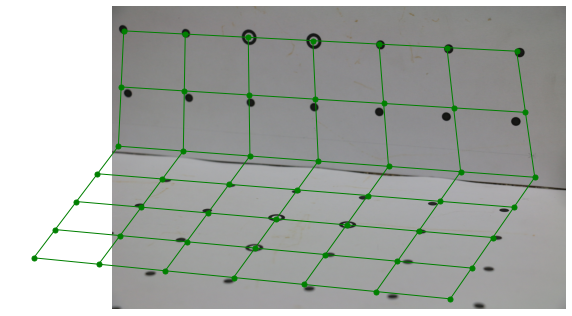

In [35]:
draw_wireframe(dots_img, P_dlt, wireframe_points, shape = [7,7])

In [36]:
reprojection_error(world_points.T, image_points.T, P_dlt)

76.53905186441973

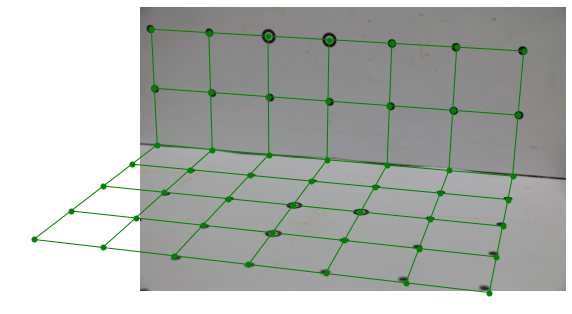

In [37]:
draw_wireframe(dots_img, P_ransac, wireframe_points, shape = [7,7])

In [38]:
reprojection_error(world_points.T, image_points.T, P_ransac)

19.863886570421286

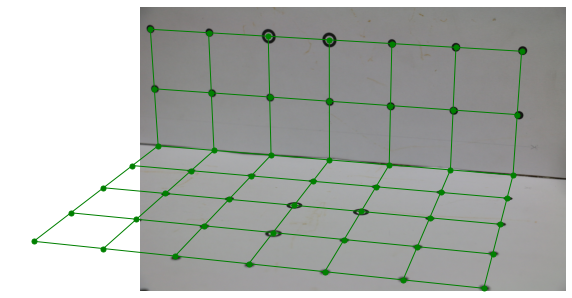

In [39]:
draw_wireframe(dots_img, P_dlt_all, wireframe_points, shape = [7,7])

In [40]:
reprojection_error(world_points.T, image_points.T, P_dlt_all)

6.337347752677584

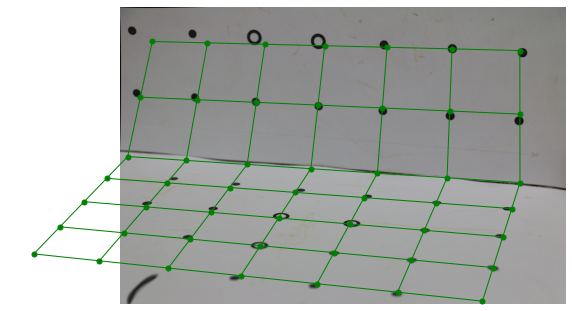

In [41]:
draw_wireframe(new_dots, P_ransac_undis, wireframe_points, shape = [7,7])

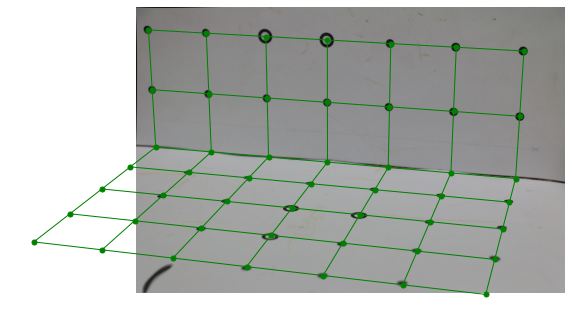

In [42]:
draw_wireframe(new_dots, P_dlt_undis, wireframe_points, shape = [7,7])

__Observations:__ As expected from the error observations, the P matrix obtained using DLT on all point correspondences gives a better fitting wireframe compared to Ransac and DLT on 6 points.

I have used extra points for wireframe just to make it look better and also for making the implementation of code more general and easier.

__6. Repeat the calibration of the camera using Zhang’s method using either the available OpenCV or Matlab
implementation. How does your results compare with DLT based method?__

In [43]:
import glob

chess_images = []
paths = sorted(glob.glob("../data/check*.JPG"))
for path in paths:
    chess_images.append(cv2.imread(path))

In [44]:
paths

['../data/checkerboard-01.JPG',
 '../data/checkerboard-02.JPG',
 '../data/checkerboard-03.JPG',
 '../data/checkerboard-04.JPG',
 '../data/checkerboard-05.JPG',
 '../data/checkerboard-06.JPG',
 '../data/checkerboard-07.JPG',
 '../data/checkerboard-08.JPG',
 '../data/checkerboard-09.JPG',
 '../data/checkerboard-10.JPG',
 '../data/checkerboard-11.JPG',
 '../data/checkerboard-12.JPG',
 '../data/checkerboard-13.JPG',
 '../data/checkerboard-14.JPG',
 '../data/checkerboard-15.JPG']

In [45]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:6,0:8].T.reshape(-1,2)

objpoints = []
imgpoints = []

for img in chess_images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (6,8), None)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        cv2.drawChessboardCorners(img, (6,8), corners, ret)
        cv2.namedWindow('img', cv2.WINDOW_NORMAL)
        cv2.imshow('img', img)
        cv2.resizeWindow('img', 1500, 1500)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [46]:
ret, K_zhang, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [47]:
K_zhang

array([[1.36415093e+04, 0.00000000e+00, 3.31635835e+03],
       [0.00000000e+00, 1.36632517e+04, 1.50037365e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

__7. Repeat the overlay of wireframe using the internal parameters estimated from Zhang’s method. Describe your
observations.__

In [48]:
# def eulerAnglesToRotationMatrix(theta) :
#     R_x = np.array([[1,0,0],[0,math.cos(theta[0]),-math.sin(theta[0])],[0,math.sin(theta[0]), math.cos(theta[0])]])
#     R_y = np.array([[math.cos(theta[1]),0,math.sin(theta[1])],[0,1,0],[-math.sin(theta[1]),0,math.cos(theta[1])]])             
#     R_z = np.array([[math.cos(theta[2]),-math.sin(theta[2]),0],[math.sin(theta[2]),math.cos(theta[2]),0],[0,0,1]])
#     R = np.dot(R_z,np.dot(R_y,R_x))
#     return R

In [49]:
def draw_wireframe_zhang(img, rvec, tvec, mtx, dist, wireframe_points, shape, color = 'green', linewidth = 1):
    x_hat = cv2.projectPoints(wireframe_points, rvec, tvec, mtx, dist)[0].reshape((-1,2))
    # x_hat[0]
    # x_hat.shape
    plt.imshow(img)
    plt.axis("off")

    for i in range(0, x_hat.shape[0] - 1, shape[1]):
        for j in range(i, i+shape[1]-1):
            # plt.imshow(img)
            plt.plot([x_hat[j,0], x_hat[j+1,0]], [x_hat[j,1], x_hat[j+1,1]], 
                     color = color, linewidth = linewidth)
            # print(j)
            # plt.show()

    for i in range(shape[1]):
        for j in range(shape[0]-1):
            # plt.imshow(img)
            plt.plot([x_hat[i+shape[1]*j,0], x_hat[i+shape[1]*(j+1),0]], 
                     [x_hat[i+shape[1]*j,1], x_hat[i+shape[1]*(j+1),1]], 
                     color = color, linewidth = linewidth)
            # plt.show()
    plt.show()

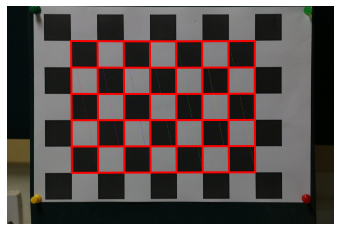

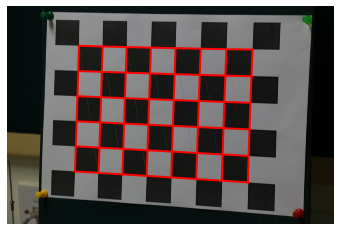

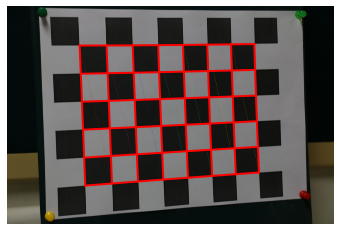

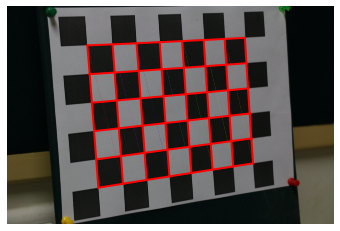

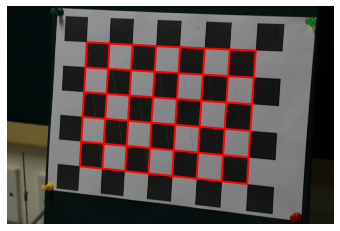

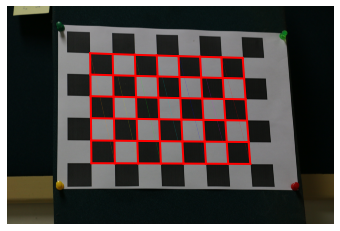

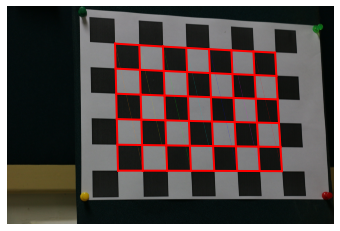

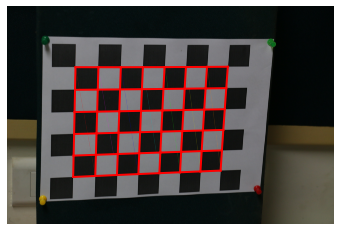

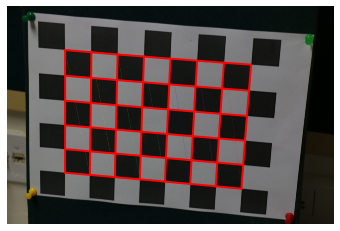

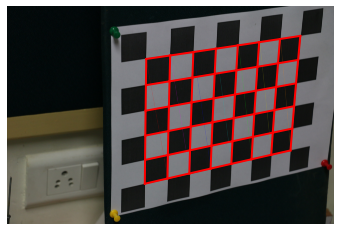

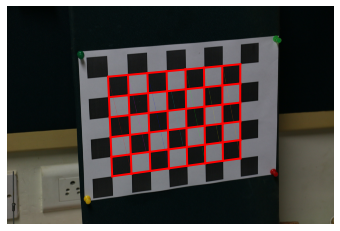

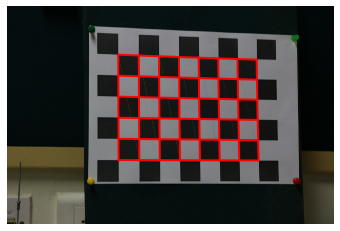

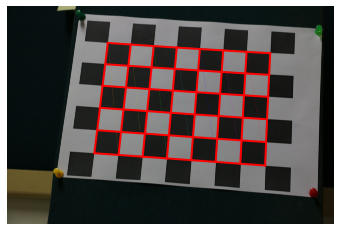

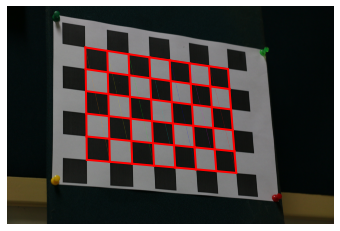

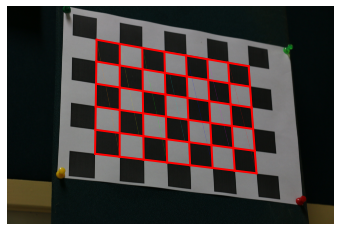

In [50]:
for i in range(len(chess_images)):
# P = K_zhang @ np.hstack((R, tvecs[0]))
# i = 0
    draw_wireframe_zhang(cv2.cvtColor(chess_images[i], cv2.COLOR_BGR2RGB), 
                   rvecs[i], tvecs[i], K_zhang, dist, objpoints[i], [8,6], 'red', 2)

__Observations:__ Gives almost perfect wireframe images, implying that the camera parameters generated by Zhang's method are very precise.

__8. What is the image of the world origin, given the calibration matrix?
observations?__

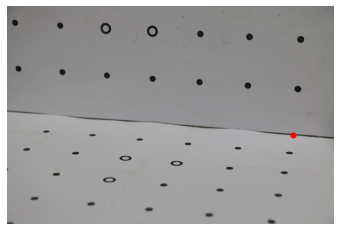

In [51]:
plt.imshow(dots_img)
plt.axis("off")

origin = np.array([[0,0,0]])
img_point = project(origin, P_dlt_all)[0]

plt.plot([img_point[0]], [img_point[1]], marker='o', markersize = 5, color="red")
plt.show()

In [52]:
P_dlt_all[:, 3]

array([4.80076993e+03, 2.15958669e+03, 1.00000000e+00])

In [53]:
img_point

array([4800.76993429, 2159.58668681])

__Observations:__ As we can see from the above image and the comparision between matrix P and image point of world origin, p4 = 4th column of P is the image of world origin

__9. Select a camera that you would like to use for the assignments. Note that you might be using this camera for
future assignments also. This could be your laptop camera, mobile phone camera or any other digital camera
that you have access to.__

Mobile phone camera

__10. Repeat the 3 calibration methods using your own camera and your own calibration object for which you measure
and determine the world co-ordinates. Use a printed checkerboard pattern for Zhang’s method. Describe and
comment on the results of each method.__

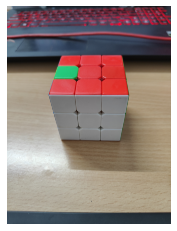

In [54]:
cube = cv2.cvtColor(cv2.imread("../images/cube1.jpg"), cv2.COLOR_BGR2RGB)
plt.imshow(cube)
plt.axis('off')
plt.show()

In [55]:
# x,y format, found by using hovering tool
image_points = np.array([[1030, 1384, 1773, 2140,
                         957, 1355, 1774, 2182,
                         882, 1312, 1778, 2226,
                         787, 1268, 1774, 2281,
                         875, 1307, 1762, 2212,
                         954, 1341, 1753, 2152,
                         1023, 1364, 1744, 2112],
                         [929, 929, 929, 929,
                         1125, 1125, 1125, 1125,
                         1370, 1370, 1370, 1370,
                         1660, 1660, 1660, 1660,
                         2000, 2000, 2015, 2021,
                         2285, 2287, 2300, 2310,
                         2508, 2511, 2521, 2527]])

# as per measurements
world_points = np.array([[3, 2, 1, 0,
                         3, 2, 1, 0,
                         3, 2, 1, 0,
                         3, 2, 1, 0,
                         3, 2, 1, 0,
                         3, 2, 1, 0,
                         3, 2, 1, 0,],
                        [3, 3, 3, 3,
                        2, 2, 2, 2,
                        1, 1, 1, 1,
                        0, 0, 0, 0,
                        0, 0, 0, 0,
                        0, 0, 0, 0,
                        0, 0, 0, 0],
                        [0, 0, 0, 0,
                        0, 0, 0, 0,
                        0, 0, 0, 0,
                        0, 0, 0, 0,
                        1, 1, 1, 1,
                        2, 2, 2, 2,
                        3, 3, 3, 3]])

In [56]:
image_points.shape

(2, 28)

In [57]:
world_points.shape

(3, 28)

In [58]:
P_ransac = ransac(world_points.T, image_points.T, 50, 0.1, num_points = 6, set_seed = True)
P_ransac

/home/laksh-nanwani/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/laksh-nanwani/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


array([[-4.87165559e+02,  1.57292099e+02,  1.74919381e+02,
         2.27835466e+03],
       [ 6.44549821e+00, -1.68798208e+02,  5.56058732e+02,
         1.68564629e+03],
       [ 6.75999730e-03,  8.98815419e-02,  1.09076834e-01,
         1.00000000e+00]])

In [59]:
K_ransac, R, T = KRT_decomposition(P_dlt_all)
K_ransac, R, T

(array([[-2.25789201e+01, -1.64705956e-01,  5.47469862e+00],
        [ 0.00000000e+00,  2.25671328e+01,  3.94069601e+00],
        [ 0.00000000e+00,  0.00000000e+00,  1.75651164e-03]]),
 array([[ 0.97846789, -0.0107263 ,  0.2061202 ],
        [-0.08403913, -0.93282343,  0.35039674],
        [ 0.18851529, -0.36017412, -0.9136392 ]]),
 array([[-74.55431219],
        [ -3.71743139],
        [569.31020474]]))

In [60]:
reprojection_error(world_points.T, image_points.T, P_ransac)

12.217194927472242

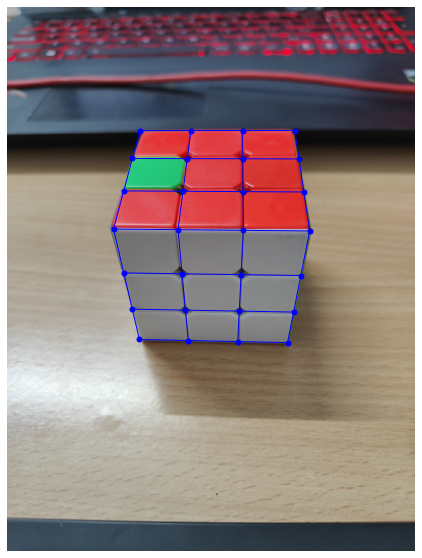

In [61]:
draw_wireframe(cube, P_ransac, world_points, [7,4], color = 'blue', linewidth = 1)

In [62]:
P_dlt_all = dlt_calibrate(world_points.T, image_points.T)
P_dlt_all

array([[-4.93687865e+02,  2.02620119e+02,  2.09572003e+02,
         2.28269774e+03],
       [ 1.14709357e+01, -1.40139318e+02,  6.09322460e+02,
         1.66749877e+03],
       [ 9.22017203e-03,  1.15991694e-01,  1.26863564e-01,
         1.00000000e+00]])

In [63]:
K_dlt_all, R, T = KRT_decomposition(P_dlt_all)
K_dlt_all/ K_dlt_all[2,2], R, T

(array([[ 2.95480436e+03,  3.74968992e+00,  1.53668970e+03],
        [-0.00000000e+00, -2.98958272e+03,  2.06360006e+03],
        [-0.00000000e+00, -0.00000000e+00,  1.00000000e+00]]),
 array([[ 0.99845665, -0.04698879, -0.02960372],
        [-0.01468181, -0.73741142,  0.67528426],
        [-0.05356091, -0.67380743, -0.73696322]]),
 array([[-1.46566381],
        [-0.76967004],
        [-5.80910067]]))

In [64]:
reprojection_error(world_points.T, image_points.T, P_dlt_all)

4.662658818300848

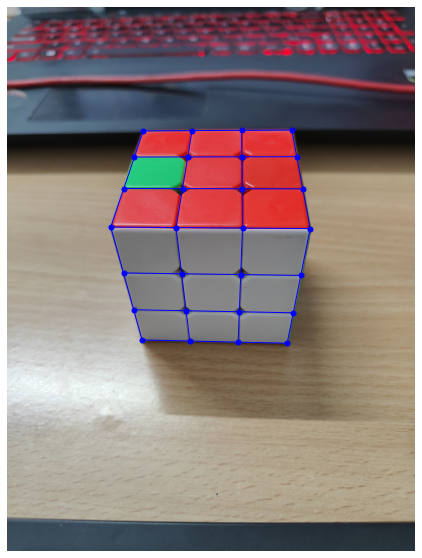

In [65]:
draw_wireframe(cube, P_dlt_all, world_points, [7,4], color = 'blue', linewidth = 1)

In [66]:
# import glob

chess_images = []
paths = sorted(glob.glob("../images/chess*.jpg"))
for path in paths:
    chess_images.append(cv2.imread(path))

In [67]:
paths

['../images/chess1.jpg',
 '../images/chess2.jpg',
 '../images/chess3.jpg',
 '../images/chess4.jpg',
 '../images/chess5.jpg',
 '../images/chess6.jpg',
 '../images/chess7.jpg',
 '../images/chess8.jpg',
 '../images/chess9.jpg']

In [68]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:6,0:8].T.reshape(-1,2)

objpoints = []
imgpoints = []

for img in chess_images:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (6,8), None)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        cv2.drawChessboardCorners(img, (6,8), corners, ret)
        cv2.namedWindow('img', cv2.WINDOW_NORMAL)
        cv2.imshow('img', img)
        cv2.resizeWindow('img', 1500, 1500)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [69]:
ret, K_zhang, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [70]:
dist

array([[ 2.14191793e-01, -1.58895466e+00, -1.26023407e-03,
        -2.92320920e-03,  3.35333816e+00]])

In [71]:
K_zhang

array([[2.93946609e+03, 0.00000000e+00, 1.50150202e+03],
       [0.00000000e+00, 2.94735475e+03, 2.03918610e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

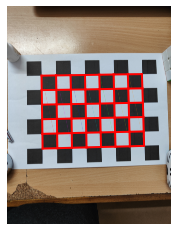

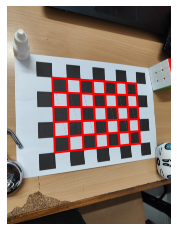

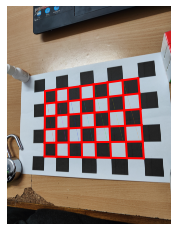

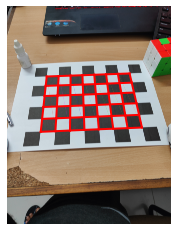

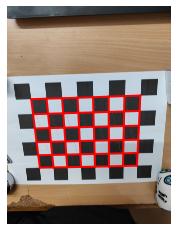

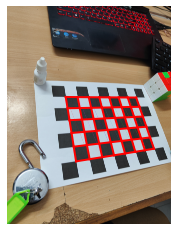

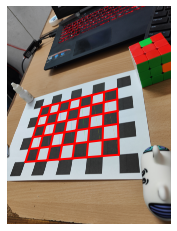

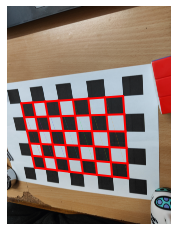

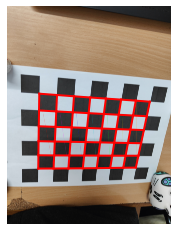

In [72]:
for i in range(len(chess_images)):
# P = K_zhang @ np.hstack((R, tvecs[0]))
# i = 0
    draw_wireframe_zhang(cv2.cvtColor(chess_images[i], cv2.COLOR_BGR2RGB), 
                         rvecs[i], tvecs[i], K_zhang, dist, objpoints[i], [8,6], 'red', 2)

In [73]:
K_dlt_all/ K_dlt_all[2,2]

array([[ 2.95480436e+03,  3.74968992e+00,  1.53668970e+03],
       [-0.00000000e+00, -2.98958272e+03,  2.06360006e+03],
       [-0.00000000e+00, -0.00000000e+00,  1.00000000e+00]])

In [74]:
K_zhang

array([[2.93946609e+03, 0.00000000e+00, 1.50150202e+03],
       [0.00000000e+00, 2.94735475e+03, 2.03918610e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

__Observations:__ As can be seen on the images above, Zhangs method provides more accurate camera parameters compared to DLT and Ransac, and again the DLT with all points gives better output than ransac.

We can observe that the K matrix by Zhang gives a basic K matrix with skew = 0 and both focal lengths almost equal. Whereas, K matrix from DLT has a skew factor and difference in x and y focal lengths. 

We can also observe that both the methods are providing almost similar x focal lengths and the image center.

__Challenges faced:__ Was already somewhat familiar with the concepts, hence didn't face many. Had an issue with implementing the Harris corner detector, hence decided to give image coordinates manually.

---

In [75]:
# # Harris Corner Detection Method

# image = cv2.imread('../data/black-dots.JPG')

# operatedImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# operatedImage = np.float32(operatedImage)

# dest = cv2.cornerHarris(operatedImage, 5, 5, 0.04)

# dest = cv2.dilate(dest, None)

# image[dest > 0.01 * dest.max()]=[0, 0, 255]

# # the window showing output image with corners
# # coordinates = peak_local_max(dest, min_distance=100)
# # plt.imshow(dest > 0.0001 * dest.max(), cmap = 'gray')
# plt.imshow(cv2.adaptiveThreshold(dest, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
#                                           cv2.THRESH_BINARY, 199, 5))
# # plt.plot(coordinates[:, 1], coordinates[:, 0])
# # dest

# # De-allocate any associated memory usage
# if cv2.waitKey(0) & 0xff == 27:
# 	cv2.destroyAllWindows()
